<center>
<img src="../../img/ml_theme.png">
# Дополнительное профессиональное <br> образование НИУ ВШЭ
#### Программа "Практический анализ данных и машинное обучение"
<img src="../../img/faculty_logo.jpg" height="240" width="240">
## Автор материала: старший преподаватель Факультета Компьютерных Наук ВШЭ, программист-исследователь Mail.ru Group  Юрий Кашницкий
</center>
Материал распространяется на условиях лицензии <a href="https://opensource.org/licenses/MS-RL">Ms-RL</a>. Можно использовать в любых целях, кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Домашнее задание №3. Построение дерева решений</center>

**Цель задания - "на пальцах", с помощью игрушечных задач классификации разобраться в том, как работают деревья решений. Напомню, само по себе дерево решений - довольно слабый алгоритм, но основанные на нем алгоритмы случайного леса и градиентного бустинга - пожалуй, лучшее, что есть на сегодняшний день. Поэтому разобраться в том, как работет дерево решений, полезно.**

**Рассмотрим 3 игрушечных задачи бинарной классификации (символ $\tau$ вместо знака вопроса обозначает неизвестные метки целевого класса тестовых объектов):**
<img src='../../img/toy_clf_task1.png'>
<img src='../../img/toy_clf_task2.png'>
<img src='../../img/toy_clf_task3.png'>

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import collections

### Загрузка данных

In [2]:
# Создание датафрейма с dummy variables
def create_df(dic, feature_list):
    out = pd.DataFrame(dic)
    out = pd.concat([out, pd.get_dummies(out[feature_list])], axis = 1)
    out.drop(feature_list, axis = 1, inplace = True)
    return out

# Некоторые значения признаков есть в тесте, но нет в трейне и наоборот
def intersect_features(train, test):
    f = list( set(train.keys()) & set(test.keys()))
    return train[f], test[f]

### Игрушечный набор данных №1. "Служба знакомств"

In [3]:
fn_1 = ['Возраст', 'Доход','Внешность','Образование'] # знакомства
fn_2 = ['Цвет', 'Тип', 'Производство', 'Повреждения'] # угон
fn_3 = ['Пол', 'Возраст', 'Образование', 'Зарпалата'] # кредит

**Обучающая выборка**

In [4]:
df1_train = {}
df1_train['Возраст'] = ['молодой','средний','пожилой','средний','молодой','средний','пожилой'] 
df1_train['Доход'] = ['высокий','высокий','высокий','средний','низкий','высокий','средний']
df1_train['Внешность'] = ['приятная','приятная','приятная','приятная','приятная','отталкивающая','приятная']
df1_train['Образование'] = ['специальное','высшее','высшее','высшее','специальное','высшее','среднее']
df1_train['Составит пару'] = LabelEncoder().fit_transform(['+','+','+','+','-','-','-'])

df1_train = create_df(df1_train, fn_1)
df1_train

,Составит пару,Возраст_молодой,Возраст_пожилой,Возраст_средний,Доход_высокий,Доход_низкий,Доход_средний,Внешность_отталкивающая,Внешность_приятная,Образование_высшее,Образование_специальное,Образование_среднее
0,0,1,0,0,1,0,0,0,1,0,1,0
1,0,0,0,1,1,0,0,0,1,1,0,0
2,0,0,1,0,1,0,0,0,1,1,0,0
3,0,0,0,1,0,0,1,0,1,1,0,0
4,1,1,0,0,0,1,0,0,1,0,1,0
5,1,0,0,1,1,0,0,1,0,1,0,0
6,1,0,1,0,0,0,1,0,1,0,0,1


**Тестовая выборка**

In [5]:
df1_test = {}
df1_test['Возраст'] = ['молодой','средний','пожилой'] 
df1_test['Доход'] = ['средний','высокий','низкий']
df1_test['Внешность'] = ['приятная','отталкивающая','приятная']
df1_test['Образование'] = ['высшее','специальное','высшее']
df1_test = create_df(df1_test, fn_1)
df1_test

,Возраст_молодой,Возраст_пожилой,Возраст_средний,Доход_высокий,Доход_низкий,Доход_средний,Внешность_отталкивающая,Внешность_приятная,Образование_высшее,Образование_специальное
0,1,0,0,0,0,1,0,1,1,0
1,0,0,1,1,0,0,1,0,0,1
2,0,1,0,0,1,0,0,1,1,0


In [6]:
# Некоторые значения признаков есть в тесте, но нет в трейне и наоборот
y_1 = df1_train['Составит пару']
df1_train, df1_test = intersect_features(train = df1_train, test = df1_test)
df1_train

,Доход_низкий,Образование_специальное,Внешность_отталкивающая,Возраст_пожилой,Доход_высокий,Доход_средний,Образование_высшее,Возраст_молодой,Внешность_приятная,Возраст_средний
0,0,1,0,0,1,0,0,1,1,0
1,0,0,0,0,1,0,1,0,1,1
2,0,0,0,1,1,0,1,0,1,0
3,0,0,0,0,0,1,1,0,1,1
4,1,1,0,0,0,0,0,1,1,0
5,0,0,1,0,1,0,1,0,0,1
6,0,0,0,1,0,1,0,0,1,0


In [7]:
df1_test

,Доход_низкий,Образование_специальное,Внешность_отталкивающая,Возраст_пожилой,Доход_высокий,Доход_средний,Образование_высшее,Возраст_молодой,Внешность_приятная,Возраст_средний
0,0,0,0,0,0,1,1,1,1,0
1,0,1,1,0,1,0,0,0,0,1
2,1,0,0,1,0,0,1,0,1,0


### Игрушечный набор данных №2. "Автоугон"

In [8]:
# обучение

df2_train = {}
df2_train['Цвет'] = ['Красный','Желтый','Желтый','Красный','Желтый','Желтый','Красный'] 
df2_train['Тип'] = ['Спортивный','Спортивный','Джип','Спортивный','Спортивный','Джип','Джип']
df2_train['Производство'] = ['США','Япония','Япония','Япония','США','США','Япония']
df2_train['Повреждения'] = ['нет','нет','нет','есть','есть','нет','есть']
df2_train['Угоняют'] = LabelEncoder().fit_transform(['+','+','+','+','-','-','-'])

df2_train = create_df(df2_train, fn_2)
df2_train

,Угоняют,Цвет_Желтый,Цвет_Красный,Тип_Джип,Тип_Спортивный,Производство_США,Производство_Япония,Повреждения_есть,Повреждения_нет
0,0,0,1,0,1,1,0,0,1
1,0,1,0,0,1,0,1,0,1
2,0,1,0,1,0,0,1,0,1
3,0,0,1,0,1,0,1,1,0
4,1,1,0,0,1,1,0,1,0
5,1,1,0,1,0,1,0,0,1
6,1,0,1,1,0,0,1,1,0


In [9]:
# тест
df2_test = {}
df2_test['Цвет'] = ['Зеленый','Красный','Черный'] 
df2_test['Тип'] = ['Спортивный','Спортивный','Джип']
df2_test['Производство'] = ['США','Германия','Япония']
df2_test['Повреждения'] = ['нет','нет','нет']

df2_test = create_df(df2_test, fn_2)
df2_test

,Цвет_Зеленый,Цвет_Красный,Цвет_Черный,Тип_Джип,Тип_Спортивный,Производство_Германия,Производство_США,Производство_Япония,Повреждения_нет
0,1,0,0,0,1,0,1,0,1
1,0,1,0,0,1,1,0,0,1
2,0,0,1,1,0,0,0,1,1


In [10]:
# Некоторые значения признаков есть в тесте, но нет в трейне и наоборот
y_2 = df2_train['Угоняют']
df2_train, df2_test = intersect_features(train = df2_train, test = df2_test)
df2_train

,Тип_Джип,Тип_Спортивный,Производство_США,Производство_Япония,Повреждения_нет,Цвет_Красный
0,0,1,1,0,1,1
1,0,1,0,1,1,0
2,1,0,0,1,1,0
3,0,1,0,1,0,1
4,0,1,1,0,0,0
5,1,0,1,0,1,0
6,1,0,0,1,0,1


In [11]:
df2_test

,Тип_Джип,Тип_Спортивный,Производство_США,Производство_Япония,Повреждения_нет,Цвет_Красный
0,0,1,1,0,1,0
1,0,1,0,0,1,1
2,1,0,0,1,1,0


### Игрушечный набор данных №3. "Выдача кредита"

In [12]:
# обучение

df3_train = {}
df3_train['Пол'] = LabelEncoder().fit_transform(['М','Ж','Ж','М','М','Ж','Ж'])
df3_train['Возраст'] = ['молодой','средний','средний','пожилой','молодой','средний','пожилой']
df3_train['Образование'] = ['высшее','специальное','высшее','высшее','высшее','среднее','специальное']
df3_train['Зарпалата'] = ['высокая','высокая','средняя','высокая','низкая','средняя','средняя']
df3_train['Выдать кредит'] = LabelEncoder().fit_transform(['+','+','+','+','-','-','-'])

df3_train = create_df(df3_train, fn_3)
df3_train['Пол'] = LabelEncoder().fit_transform(['М','Ж','Ж','М','М','Ж','Ж'])
df3_train

,Выдать кредит,Возраст_молодой,Возраст_пожилой,Возраст_средний,Образование_высшее,Образование_специальное,Образование_среднее,Зарпалата_высокая,Зарпалата_низкая,Зарпалата_средняя,Пол
0,0,1,0,0,1,0,0,1,0,0,1
1,0,0,0,1,0,1,0,1,0,0,0
2,0,0,0,1,1,0,0,0,0,1,0
3,0,0,1,0,1,0,0,1,0,0,1
4,1,1,0,0,1,0,0,0,1,0,1
5,1,0,0,1,0,0,1,0,0,1,0
6,1,0,1,0,0,1,0,0,0,1,0


In [13]:
# тест

df3_test = {}
df3_test['Пол'] =  LabelEncoder().fit_transform(['Ж','Ж','М'])
df3_test['Возраст'] = ['молодой','пожилой','средний']
df3_test['Образование'] = ['специальное','высшее','специальное']
df3_test['Зарпалата'] = ['высокая','средняя','средняя']

df3_test = create_df(df3_test, fn_3)
df3_test['Пол'] =  LabelEncoder().fit_transform(['Ж','Ж','М'])
df3_test

,Возраст_молодой,Возраст_пожилой,Возраст_средний,Образование_высшее,Образование_специальное,Зарпалата_высокая,Зарпалата_средняя,Пол
0,1,0,0,0,1,1,0,0
1,0,1,0,1,0,0,1,0
2,0,0,1,0,1,0,1,1


In [14]:
# Некоторые значения признаков есть в тесте, но нет в трейне и наоборот
y_3 = df3_train['Выдать кредит']
df3_train, df3_test = intersect_features(train = df3_train, test = df3_test)
df3_train

,Зарпалата_средняя,Образование_специальное,Зарпалата_высокая,Возраст_пожилой,Пол,Образование_высшее,Возраст_молодой,Возраст_средний
0,0,0,1,0,1,1,1,0
1,0,1,1,0,0,0,0,1
2,1,0,0,0,0,1,0,1
3,0,0,1,1,1,1,0,0
4,0,0,0,0,1,1,1,0
5,1,0,0,0,0,0,0,1
6,1,1,0,1,0,0,0,0


In [15]:
df3_test

,Зарпалата_средняя,Образование_специальное,Зарпалата_высокая,Возраст_пожилой,Пол,Образование_высшее,Возраст_молодой,Возраст_средний
0,0,1,1,0,0,0,1,0
1,1,0,0,1,0,1,0,0
2,1,1,0,0,1,0,0,1


## Функции для расчета энтропии и прироста информации

In [16]:
# данные для тестирования: 9 синих шариков и 11 желтых
b = [1 for i in range(9)] + [0 for i in range(11)]

# два разбиения
b1 = [1 for i in range(8)] + [0 for i in range(5)] # 8 синих и 5 желтых
b2 = [1 for i in range(1)] + [0 for i in range(6)] # 1 синий и 6 желтых

In [17]:
# расчет энтропии Шеннона
import math
def entropy(a_list):
    counts = np.bincount(a_list)
    probs = counts / len(a_list)
    ent = 0
    for i in probs:
        if i > 0:
            ent -= i * math.log(i, 2)
    return ent
    pass

In [18]:
print(entropy([1,0,0,0,0,0,0])) # 1 синий и 6 желтых
print(entropy(b))
print(entropy([1,2,3,4,5,6])) # энтропия игральной кости с несмещенным центром тяжести

0.591672778582
0.992774453988
2.58496250072


In [19]:
# расчет прироста информации

def information_gain(root, left, right):
    ''' root - изначальный набор данных, left и right два разбиения изначального набора'''
    sum_ents = (len(left)/len(root))*entropy(left) + (len(right)/len(root))*entropy(right)
    ig = entropy(root) - sum_ents
    return ig
    # Ваш код здесь
    pass

In [20]:
print(information_gain(b,b1,b2))

0.160885188414


In [21]:
# функция для расчета прироста информации при разбиении набора данных 

def split(X,y):
    ''' Выводит прирост информации при разбиении по каждому признаку'''
    ig_dict = {}
    for feature in X.columns:
        root_y = y
        left_y = y.ix[X[X[feature] == 0].index]
        right_y = y.ix[X[X[feature] == 1].index]
        ig_dict[feature] = information_gain(root_y, left_y, right_y)
    return ig_dict
    # Ваш код здесь
    pass


## Постройте деревья решений для трех наборов данных. 

**Рисовать деревья можно от руки. Дополнительно (для желающих) - отрисовка деревьев, код для построения всего дерева.**

#### Задача 1

In [22]:
split(df1_train, y_1)

{'Внешность_отталкивающая': 0.19811742113040354,
 'Внешность_приятная': 0.19811742113040354,
 'Возраст_молодой': 0.0059777114237741236,
 'Возраст_пожилой': 0.0059777114237741236,
 'Возраст_средний': 0.020244207153756189,
 'Доход_высокий': 0.12808527889139454,
 'Доход_низкий': 0.19811742113040354,
 'Доход_средний': 0.0059777114237741236,
 'Образование_высшее': 0.12808527889139454,
 'Образование_специальное': 0.0059777114237741236}

В качестве критерия выбираем  признак `'Внешность_отталкивающая'`.

In [23]:
df1_train_l = df1_train[df1_train['Внешность_отталкивающая'] == 0]
df1_train_r = df1_train[df1_train['Внешность_отталкивающая'] == 1]
y_l = y_1.ix[df1_train[df1_train['Внешность_отталкивающая'] == 0].index]
y_r = y_1.ix[df1_train[df1_train['Внешность_отталкивающая'] == 1].index]
print(y_l.values, y_r.values)

[0 0 0 0 1 1] [1]


*В данной кодировке `0` - составит пару, `1` - не составит.*

Правая вершина содержит объекты одного класса, следовательно, строим ветви дальше только для левой вершины.

In [24]:
split(df1_train_l, y_l)

{'Внешность_отталкивающая': 0.0,
 'Внешность_приятная': 0.0,
 'Возраст_молодой': 0.044110417748401076,
 'Возраст_пожилой': 0.044110417748401076,
 'Возраст_средний': 0.25162916738782293,
 'Доход_высокий': 0.45914791702724478,
 'Доход_низкий': 0.31668908831502096,
 'Доход_средний': 0.044110417748401076,
 'Образование_высшее': 0.45914791702724478,
 'Образование_специальное': 0.044110417748401076}

В качестве критерия выбираем  признак `'Доход_высокий'`, который дает прирост информации равный приросту информации при делении про признаку `'Образование_высшее'`. Между признаками выбираем произвольно. 

In [25]:
df1_train_l_l = df1_train_l[df1_train_l['Доход_высокий'] == 0]
df1_train_l_r = df1_train_l[df1_train_l['Доход_высокий'] == 1]
y_l_l = y_l.ix[df1_train_l[df1_train_l['Доход_высокий'] == 0].index]
y_l_r = y_l.ix[df1_train_l[df1_train_l['Доход_высокий'] == 1].index]
print(y_l_l.values, y_l_r.values)

[0 1 1] [0 0 0]


Правая вершина содержит объекты одного класса, следовательно, строим ветви дальше только для левой вершины.

In [26]:
split(df1_train_l_l, y_l_l)

{'Внешность_отталкивающая': 0.0,
 'Внешность_приятная': 0.0,
 'Возраст_молодой': 0.25162916738782293,
 'Возраст_пожилой': 0.25162916738782293,
 'Возраст_средний': 0.91829583405448956,
 'Доход_высокий': 0.0,
 'Доход_низкий': 0.25162916738782293,
 'Доход_средний': 0.25162916738782293,
 'Образование_высшее': 0.91829583405448956,
 'Образование_специальное': 0.25162916738782293}

В качестве критерия выбираем признак `'Возраст_средний'`, который дает прирост информации равный приросту информации при делении про признаку `'Образование_высшее'`. Между признаками выбираем произвольно.

In [27]:
df3_train_l_l_l = df1_train_l_l[df1_train_l_l['Возраст_средний'] == 0]
df3_train_l_l_r = df1_train_l_l[df1_train_l_l['Возраст_средний'] == 1]
y_l_l_l = y_l_l.ix[df1_train_l_l[df1_train_l_l['Возраст_средний'] == 0].index]
y_l_l_r = y_l_l.ix[df1_train_l_l[df1_train_l_l['Возраст_средний'] == 1].index]
print(y_l_l_l.values, y_l_l_r.values)

[1 1] [0]


Дерево готово!

<img src="Задача1.png" height="500" width="500">

#### Задача 2

In [28]:
split(df2_train, y_2)

{'Повреждения_нет': 0.12808527889139454,
 'Производство_США': 0.12808527889139454,
 'Производство_Япония': 0.12808527889139454,
 'Тип_Джип': 0.12808527889139454,
 'Тип_Спортивный': 0.12808527889139454,
 'Цвет_Красный': 0.020244207153756189}

В качестве критерия произвольно выбираем признак `'Повреждения_нет'`. Заметим, что другие признаки (кроме красного цвета) также дают равный прирост информации.   
*В данной кодировке 0 - угоняют, 1 - не угоняют.*

In [29]:
df2_train_l = df2_train[df2_train['Повреждения_нет'] == 0]
df2_train_r = df2_train[df2_train['Повреждения_нет'] == 1]
y_l = y_1.ix[df2_train[df2_train['Повреждения_нет'] == 0].index]
y_r = y_1.ix[df2_train[df2_train['Повреждения_нет'] == 1].index]
print(y_l.values, y_r.values)

[0 1 1] [0 0 0 1]


In [30]:
split(df2_train_l, y_l)

{'Повреждения_нет': 0.0,
 'Производство_США': 0.25162916738782293,
 'Производство_Япония': 0.25162916738782293,
 'Тип_Джип': 0.25162916738782293,
 'Тип_Спортивный': 0.25162916738782293,
 'Цвет_Красный': 0.25162916738782293}

В качестве критерия произвольно выбираем признак `'Производство_США'`. Заметим, что другие признаки имеют такое же значение прироста информации. 

In [31]:
df2_train_l_l = df2_train_l[df2_train_l['Производство_США'] == 0]
df2_train_l_r = df2_train_l[df2_train_l['Производство_США'] == 1]
y_l_l = y_l.ix[df2_train_l[df2_train_l['Производство_США'] == 0].index]
y_l_r = y_l.ix[df2_train_l[df2_train_l['Производство_США'] == 1].index]
print(y_l_l.values, y_l_r.values)

[0 1] [1]


Правая вершина содержит объекты одного класса, следовательно, строим ветви дальше только для левой вершины.

In [32]:
split(df2_train_l_l, y_l_l)

{'Повреждения_нет': 0.0,
 'Производство_США': 0.0,
 'Производство_Япония': 0.0,
 'Тип_Джип': 1.0,
 'Тип_Спортивный': 1.0,
 'Цвет_Красный': 0.0}

В качестве критерия произвольно выбираем признак `'Тип_Джип'`. 

In [33]:
df2_train_l_l_l = df2_train_l_l[df2_train_l_l['Тип_Джип'] == 0]
df2_train_l_l_r = df2_train_l_l[df2_train_l_l['Тип_Джип'] == 1]
y_l_l_l = y_l_l.ix[df2_train_l_l[df2_train_l_l['Тип_Джип'] == 0].index]
y_l_l_r = y_l_l.ix[df2_train_l_l[df2_train_l_l['Тип_Джип'] == 1].index]
print(y_l_l_l.values, y_l_l_r.values)

[0] [1]


Левая подветвь готова.

In [34]:
split(df2_train_r, y_r)

{'Повреждения_нет': 0.0,
 'Производство_США': 0.31127812445913283,
 'Производство_Япония': 0.31127812445913283,
 'Тип_Джип': 0.31127812445913283,
 'Тип_Спортивный': 0.31127812445913283,
 'Цвет_Красный': 0.12255624891826566}

В качестве критерия произвольно выбираем признак `'Производство_США'`. Другие признаки имеют такое же значение прироста информации. 

In [35]:
df2_train_r_l = df2_train_r[df2_train_r['Производство_США'] == 0]
df2_train_r_r = df2_train_r[df2_train_r['Производство_США'] == 1]
y_r_l = y_r.ix[df2_train_r[df2_train_r['Производство_США'] == 0].index]
y_r_r = y_r.ix[df2_train_r[df2_train_r['Производство_США'] == 1].index]
print(y_r_l.values, y_r_r.values)

[0 0] [0 1]


Левая вершина содержит объекты одного класса, следовательно, строим ветви дальше только для правой вершины.

In [36]:
split(df2_train_r_r, y_r_r)

{'Повреждения_нет': 0.0,
 'Производство_США': 0.0,
 'Производство_Япония': 0.0,
 'Тип_Джип': 1.0,
 'Тип_Спортивный': 1.0,
 'Цвет_Красный': 1.0}

В качестве критерия выбираем признак `'Тип_Джип'`. 

In [37]:
df2_train_r_r_l = df2_train_r_r[df2_train_r_r['Тип_Джип'] == 0]
df2_train_r_r_r = df2_train_r_r[df2_train_r_r['Тип_Джип'] == 1]
y_r_r_l = y_r_r.ix[df2_train_r_r[df2_train_r_r['Тип_Джип'] == 0].index]
y_r_r_r = y_r_r.ix[df2_train_r_r[df2_train_r_r['Тип_Джип'] == 1].index]
print(y_r_r_l.values, y_r_r_r.values)

[0] [1]


Дерево готово!

<img src="Задача2.png" height="600" width="600">

#### Задача 3

In [38]:
split(df2_train, y_2)

{'Повреждения_нет': 0.12808527889139454,
 'Производство_США': 0.12808527889139454,
 'Производство_Япония': 0.12808527889139454,
 'Тип_Джип': 0.12808527889139454,
 'Тип_Спортивный': 0.12808527889139454,
 'Цвет_Красный': 0.020244207153756189}

В качестве критерия выбираем  признак `'Зарпалата_высокая'`.

In [39]:
df3_train_l = df3_train[df3_train['Зарпалата_высокая'] == 0]
df3_train_r = df3_train[df3_train['Зарпалата_высокая'] == 1]
y_l = y_3.ix[df3_train[df3_train['Зарпалата_высокая'] == 0].index]
y_r = y_3.ix[df3_train[df3_train['Зарпалата_высокая'] == 1].index]
print(y_l.values, y_r.values)

[0 1 1 1] [0 0 0]


*В данной кодировке `0` - выдать, `1` - не выдавать.*

Правая вершина содержит объекты одного класса, следовательно, строим ветви дальше только для левой вершины.

In [40]:
split(df3_train_l, y_l)

{'Возраст_молодой': 0.12255624891826566,
 'Возраст_пожилой': 0.12255624891826566,
 'Возраст_средний': 0.31127812445913283,
 'Зарпалата_высокая': 0.0,
 'Зарпалата_средняя': 0.12255624891826566,
 'Образование_высшее': 0.31127812445913283,
 'Образование_специальное': 0.12255624891826566,
 'Пол': 0.12255624891826566}

В качестве критерия выбираем  признак `'Образование_высшее'`, который дает прирост информации равный приросту информации при делении про признаку `'Возраст_средний'`. Между признаками выбираем произвольно. 

In [41]:
df3_train_l_l = df3_train_l[df3_train_l['Образование_высшее'] == 0]
df3_train_l_r = df3_train_l[df3_train_l['Образование_высшее'] == 1]
y_l_l = y_l.ix[df3_train_l[df3_train_l['Образование_высшее'] == 0].index]
y_l_r = y_l.ix[df3_train_l[df3_train_l['Образование_высшее'] == 1].index]
print(y_l_l.values, y_l_r.values)

[1 1] [0 1]


Левая вершина содержит объекты одного класса, следовательно, строим ветви дальше только для правой вершины.

In [42]:
split(df3_train_l_r, y_l_r)

{'Возраст_молодой': 1.0,
 'Возраст_пожилой': 0.0,
 'Возраст_средний': 1.0,
 'Зарпалата_высокая': 0.0,
 'Зарпалата_средняя': 1.0,
 'Образование_высшее': 0.0,
 'Образование_специальное': 0.0,
 'Пол': 1.0}

Выбираем первый из признаков, дающих хорошее разделение - `'Возраст_молодой'`. 

In [43]:
df3_train_l_r_l = df3_train_l_r[df3_train_l_r['Возраст_молодой'] == 0]
df3_train_l_r_r = df3_train_l_r[df3_train_l_r['Возраст_молодой'] == 1]
y_l_r_l = y_l_r.ix[df3_train_l_r[df3_train_l_r['Возраст_молодой'] == 0].index]
y_l_r_r = y_l_r.ix[df3_train_l_r[df3_train_l_r['Возраст_молодой'] == 1].index]
print(y_l_r_l.values, y_l_r_r.values)

[0] [1]


Дерево готово!

<img src="Задача3.png" height="500" width="500">

## Постройте деревья решений для трех наборов данных с помощью sklearn

**Отобразите деревья с помощью graphviz.**

In [44]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import export_graphviz

#### Задача 1

In [60]:
tree1 = DecisionTreeClassifier(random_state = 17)
tree1.fit(df1_train, y_1)
tree1_predictions = tree1.predict(df1_test)
tree1_predictions

array([1, 1, 1], dtype=int64)

In [61]:
export_graphviz(tree1, 'tree1.dot', feature_names=df1_train.columns, filled=True)

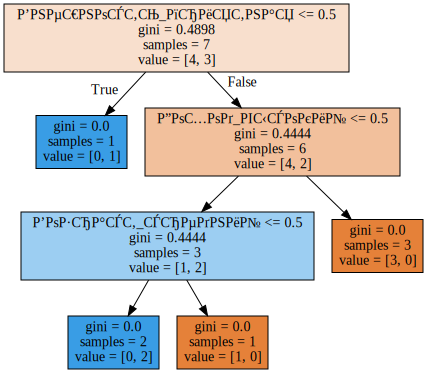

In [62]:
import graphviz
from IPython.display import display
with open("tree1.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

Из-за того, что признаки записаны кириллицей, здесь деревья строятся в виде абракадабр. Graphviz Online построил нормальное дерево:

<img src="tree1.png" height="360" width="355">

#### Задача 2

In [63]:
tree2 = DecisionTreeClassifier(random_state = 17, max_depth=2, max_features=3)
tree2.fit(df2_train, y_2)
tree2_predictions = tree2.predict(df2_test)
tree2_predictions

array([0, 0, 0], dtype=int64)

In [64]:
export_graphviz(tree2, 'tree2.dot', feature_names=df2_train.columns, filled=True)

In [54]:
# with open("tree2.dot") as f:
#     dot_graph = f.read()
# graphviz.Source(dot_graph)

<img src="tree2.png" height="700" width="800">

#### Задача 3

In [65]:
tree3 = DecisionTreeClassifier(random_state = 17, max_depth=2, max_features=4)
tree3.fit(df3_train, y_3)
tree3_predictions = tree3.predict(df3_test)
tree3_predictions

array([0, 1, 0], dtype=int64)

In [66]:
export_graphviz(tree3, 'tree3.dot', feature_names=df3_train.columns, filled=True)

In [59]:
# with open("tree3.dot") as f:
#     dot_graph = f.read()
# graphviz.Source(dot_graph)

<img src="tree3.png" height="500" width="400">